<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - Try a prediction
<!-- DESC --> Episode 1 : Data analysis and creation of a usable dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Undestand the data
 - cleanup a usable dataset


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read the data
 - Cleanup and build a usable dataset

## Step 1 - Import and init
### 1.1 - Python

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()

def np_print(*args):
    with np.printoptions(formatter={'float':'{:8.2f}'.format}, linewidth=np.inf):
        for a in args:
            print(a)    


FIDLE 2020 - Practical Work Module
Version              : 0.4.4
Run time             : Saturday 29 February 2020, 18:43:44
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


### 1.2 - Where are we ? 

In [2]:
place, dataset_dir = ooo.good_place( { 'GRICAD' : f'{os.getenv("SCRATCH_DIR","")}/PROJECTS/pr-fidle/datasets/SYNOP',
                                       'IDRIS'  : f'{os.getenv("WORK","")}/datasets/SYNOP',
                                       'HOME'   : f'{os.getenv("HOME","")}/datasets/SYNOP'} )

Well, we should be at GRICAD !
We are going to use: /bettik/PROJECTS/pr-fidle/datasets/SYNOP


## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [3]:
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
train_len        = 25000
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- Read dataset

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Train / Test

dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
ooo.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

ooo.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()


print('Dataset : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00,25000.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.80,-1.59,-1.75,-1.37,-5.18,-3.82,-0.52,-4.94,-1.64,-0.31,-0.27,-3.03
25%,-0.64,-0.85,-0.64,-0.76,-0.72,-0.71,-0.42,-0.55,-0.69,-0.15,-0.20,-0.75
50%,-0.00,-0.48,-0.12,-0.19,0.05,0.18,-0.42,0.03,-0.27,-0.15,-0.20,-0.01
75%,0.63,0.99,1.08,0.50,0.79,0.84,-0.37,0.61,0.52,-0.15,-0.20,0.72
max,7.16,1.36,1.34,6.28,2.40,1.62,4.46,3.10,6.29,30.36,31.27,3.02


Dataset :  (29165, 14)
Train dataset :  (25000, 12)
Test  dataset :  (4165, 12)


### 2.2 - Prepare data generator

In [4]:
sequence_len = 16
batch_size   = 32

# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

# x,y=train_generator[0]
# np_print(x[0])
# np_print(y[0])

Nombre de train batchs disponibles :  781
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


## Step 3 - Create a model

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(100, activation='relu', input_shape=(sequence_len, features_len)))
model.add(keras.layers.Dense(features_len))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


# Step 4 - Compile and run

### 4.1 - Callback

In [6]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [7]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit

In [8]:
%%time

history=model.fit_generator(train_generator, 
                            epochs=10, 
                            verbose=1,
                            validation_data = test_generator,
                            callbacks = [bestmodel_callback])

Epoch 1/10
781/781 [==============================] - 37s 47ms/step - loss: 0.5673 - mae: 0.4757 - val_loss: 0.4621 - val_mae: 0.4176
Epoch 2/10
781/781 [==============================] - 35s 45ms/step - loss: 0.4701 - mae: 0.4017 - val_loss: 0.4395 - val_mae: 0.3954
Epoch 3/10
781/781 [==============================] - 36s 46ms/step - loss: 0.4481 - mae: 0.3842 - val_loss: 0.4278 - val_mae: 0.3829
Epoch 4/10
781/781 [==============================] - 39s 51ms/step - loss: 0.4363 - mae: 0.3735 - val_loss: 0.4135 - val_mae: 0.3881
Epoch 5/10
781/781 [==============================] - 39s 50ms/step - loss: 0.4275 - mae: 0.3672 - val_loss: 0.4116 - val_mae: 0.3765
Epoch 6/10
781/781 [==============================] - 35s 45ms/step - loss: 0.4210 - mae: 0.3634 - val_loss: 0.4023 - val_mae: 0.3650
Epoch 7/10
781/781 [==============================] - 36s 46ms/step - loss: 0.4146 - mae: 0.3597 - val_loss: 0.4009 - val_mae: 0.3660
Epoch 8/10
781/781 [==============================] - 37s 47ms

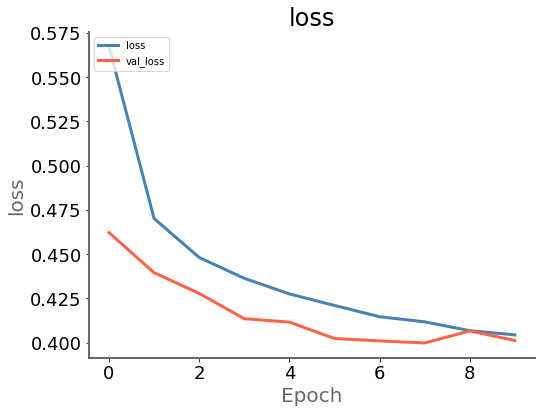

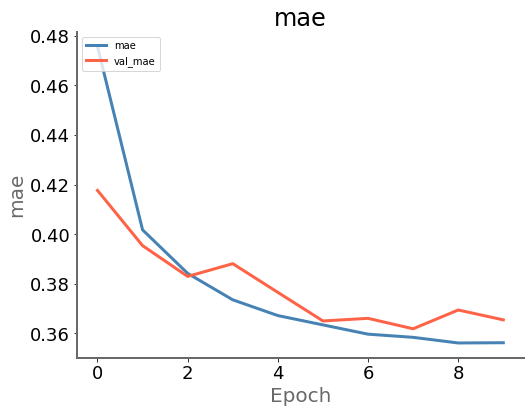

In [9]:
ooo.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']})

## Step 5 - Predict

In [10]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')

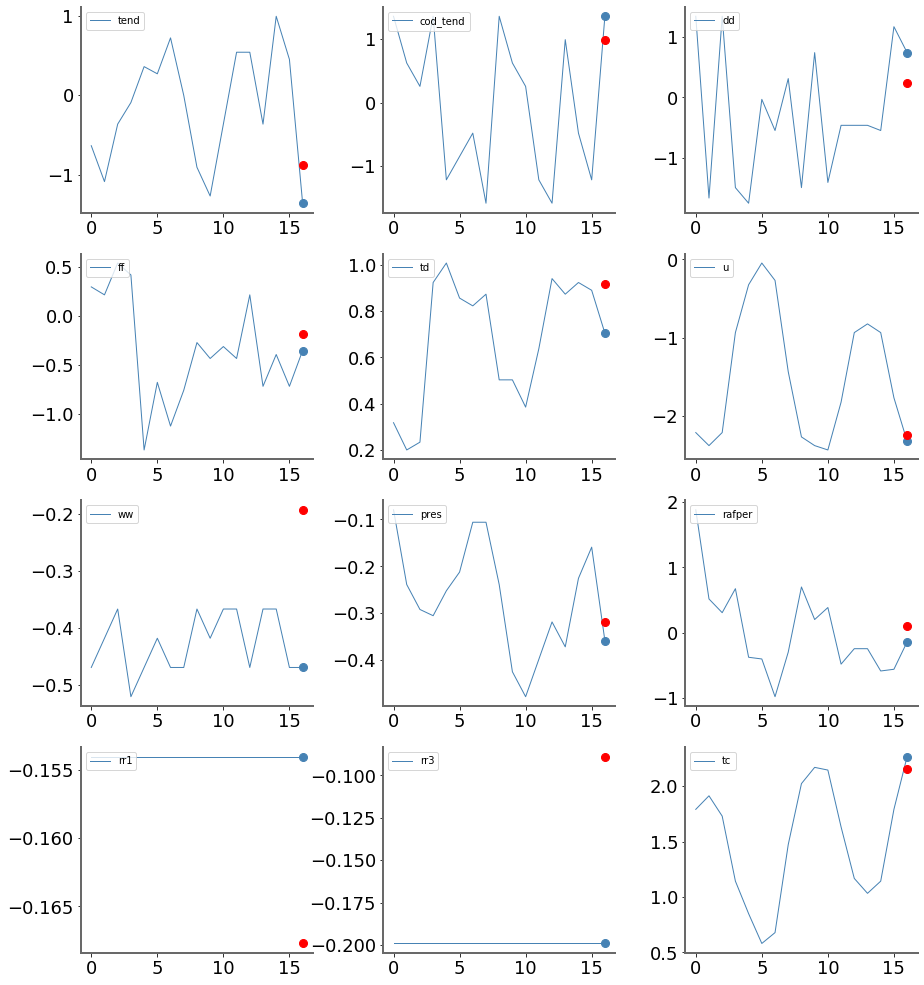

In [18]:
# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]


pred = loaded_model.predict( np.array([sequence]) )

t=np.arange(sequence_len+1)

columns = 3
width=5
height=4

rows = math.ceil(features_len/columns)
fig  = plt.figure(figsize=(columns*width, rows*(height+0.35)))
fig.subplots_adjust(wspace=0.3,hspace=0.2)
n=1
for i in range(features_len):
    ax=fig.add_subplot(rows, columns, n)
    ax.plot(t,       sequence_true[:,i],    '-',  linewidth=1, color='steelblue', label=features[i])
    ax.plot(t[-1],   sequence_true[-1:,i],  'o',  fillstyle='full',  markersize=8, color='steelblue') # ce qui nous interesse
    ax.plot(t[-1],   [pred[0][i]],          'o',  fillstyle='full',  markersize=8, color='red') # ce qui nous interesse

    ax.legend(loc="upper left")
    n+=1
plt.show()

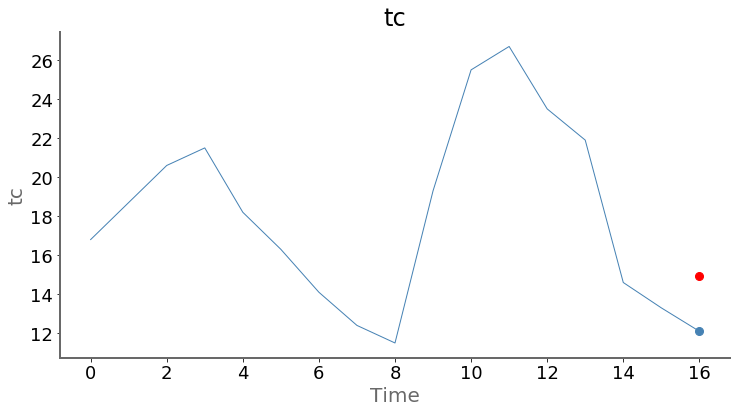

In [103]:
# ---- Get a sequence


i=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

for i,s in enumerate(sequence_true):
    s = s*std + mean
    sequence_true[i]=s

for i,s in enumerate(pred):
    s = s*std + mean
    pred[i]=s


    
c=11

t=np.arange(sequence_len+1)

plt.figure(figsize=(12,6))
plt.title(features[c])
plt.ylabel(features[c])
plt.xlabel('Time')
plt.plot(t,       sequence_true[:,c],    '-',  linewidth=1, color='steelblue')
plt.plot(t[-1],   sequence_true[-1:,c],  'o',  fillstyle='full',  markersize=8, color='steelblue') # ce qui nous interesse
plt.plot(t[-1],   [pred[0][c]],          'o',  fillstyle='full',  markersize=8, color='red') # ce qui nous interesse
plt.show()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>